Known offset (y, x): [ 22.4  -33.32]


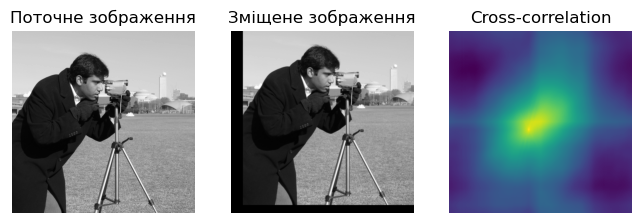

Detected pixel offset (y, x): [ 22. -33.]


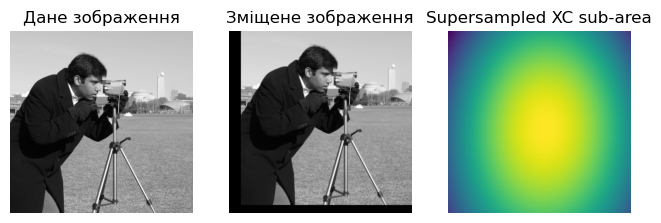

Detected subpixel offset (y, x): [ 22.272 -33.161]


In [41]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift
import cv2

image = data.camera()
shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
M = np.float32([
	[1, 0, 33.32],
	[0, 1, -22.4]
])
offset_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
print(f'Known offset (y, x): {-M[:,-1][::-1]}')

# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Поточне зображення')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Зміщене зображення')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f'Detected pixel offset (y, x): {shift}')

# subpixel precision
shift, error, diffphase = phase_cross_correlation(image, offset_image,
                                                  upsample_factor=1000)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Дане зображення')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Зміщене зображення')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print(f'Detected subpixel offset (y, x): {shift}')

Known offset (y, x): [ 22.4  -33.32]


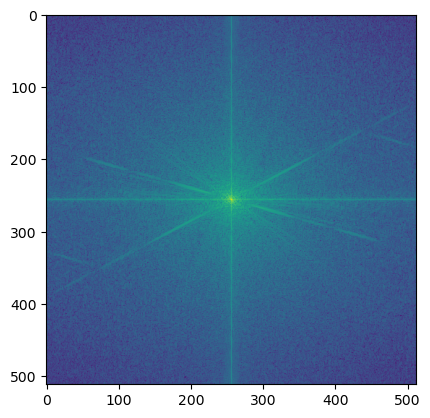

(279, 223) 23 -33


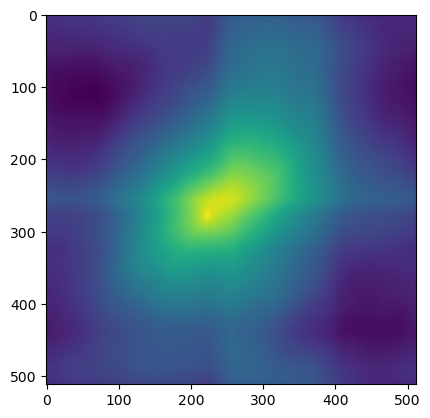

In [43]:
def cros_pow_spect(img1, img2):
    # print(rect_prev)
    f = np.fft.fft2(img1)
    fshift1 = np.fft.fftshift(f)
    f = np.fft.fft2(img2)
    fshift2 = np.fft.fftshift(f)

    cross_power_spectrum = np.conj(fshift2) *  fshift1
    plt.imshow(np.log(np.abs(cross_power_spectrum)))
    plt.show()
    f_ishift = cross_power_spectrum #/ np.abs(cross_power_spectrum)
    img_back = np.fft.fftshift(np.fft.ifft2(f_ishift))
    return img_back
print(f'Known offset (y, x): {-M[:,-1][::-1]}')

cps = cros_pow_spect(image, offset_image)
plt.imshow(np.abs(cps)) #.real)
center = cps.shape[0] // 2, cps.shape[1] // 2
shift = np.unravel_index(np.argmax(cps), cps.shape)
print(shift, shift[0] - center[0], shift[1] - center[1])